In [79]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
# import lightgbm as lgbm

%matplotlib inline

In [80]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_features.csv')

In [81]:
train.isna().sum()

name                           0
bonus                         52
deferral_payments             85
deferred_income               79
director_fees                100
email_address                 30
exercised_stock_options       32
expenses                      40
from_messages                 48
from_poi_to_this_person       48
from_this_person_to_poi       48
loan_advances                111
long_term_incentive           64
other                         44
poi                            0
restricted_stock              31
restricted_stock_deferred    103
salary                        40
shared_receipt_with_poi       48
to_messages                   48
total_payments                17
total_stock_value             15
dtype: int64

In [82]:
#這三欄NA都太多了，拿掉之後再做一次EDA Report
train.drop(['loan_advances','director_fees','restricted_stock_deferred'],axis = 1,inplace=True)
test.drop(['loan_advances','director_fees','restricted_stock_deferred'],axis = 1,inplace=True)

In [83]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['poi'] = le.fit_transform(train['poi'])

In [84]:
train.columns

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'email_address', 'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi',
       'long_term_incentive', 'other', 'poi', 'restricted_stock', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value'],
      dtype='object')

### 將EDA的結果存成HTML

In [85]:
# train_profile = train.profile_report(title='Kaggle期中競賽EDA(train)')
# train_profile.to_file(output_file="/Users/liaoshousan/Desktop/3rd-ML100Days/Homework/Kaggle 期中競賽/trainoutput.html")

In [86]:
# test_profile = test.profile_report(title='Kaggle期中競賽EDA(test)')
# test_profile.to_file(output_file="/Users/liaoshousan/Desktop/3rd-ML100Days/Homework/Kaggle 期中競賽/testoutput.html")

### 用R跑了一些繪圖後，得出的一點小結論

In [87]:
# other 好像沒什麼用(大或小都有人詐欺)
# total_stock_value 和 exercised_stock_options 高度線性相關，且exercised_stock_options高的人詐欺機率高
# 對exercised_stock_options 以1e+07為界做切割
# from_this_person_to_poi 好像沒什麼用(都小於100次)
# from_poi_to_this_person 好像也不明顯
# salary 感覺看不出來有特徵，但其中兩個詐欺犯salary特別高

### exercised_stock_options 切割成兩區

In [88]:
train['exercised_stock_options_segment'] = train['exercised_stock_options'].apply(lambda x:1 if x>10000000 else 0)
test['exercised_stock_options_segment'] = test['exercised_stock_options'].apply(lambda x:1 if x>10000000 else 0)


### 別人做的project新增的變數

In [89]:
train['bonus_to_salary'] = train['bonus'] / train['salary'] #比對bonus 和salary的比例
train['bonus_to_total'] = train['bonus'] / train['total_payments'] # 比對bonus和總收入的比例

test['bonus_to_salary'] = train['bonus'] / test['salary'] #比對bonus 和salary的比例
test['bonus_to_total'] = train['bonus'] / test['total_payments'] # 比對bonus和總收入的比例



In [90]:
# 對E-mail的資訊新增一些新的變數
train['to_poi_ratio'] = train['from_poi_to_this_person'] / train['to_messages']
train['from_poi_ratio'] = train['from_this_person_to_poi'] / train['from_messages']
train['shared_poi_ratio'] = train['shared_receipt_with_poi'] / train['to_messages']

test['to_poi_ratio'] = test['from_poi_to_this_person'] / test['to_messages']
test['from_poi_ratio'] = test['from_this_person_to_poi'] / test['from_messages']
test['shared_poi_ratio'] = test['shared_receipt_with_poi'] / test['to_messages']

### 加入上述的變數，roc_auc進步到0.8125

### 衍伸欄位都做完了，將空值填0

In [91]:
train.fillna(0,inplace = True)
test.fillna(0,inplace = True)

In [92]:
y = train['poi']
train = train.drop(['poi','name','email_address'],axis = 1)
test = test.drop(['name','email_address'],axis = 1)

In [93]:
train.head()

,bonus,deferral_payments,deferred_income,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,...,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,exercised_stock_options_segment,bonus_to_salary,bonus_to_total,to_poi_ratio,from_poi_ratio,shared_poi_ratio
0,1750000.0,0.0,-3504386.0,19794175.0,46950.0,18.0,42.0,4.0,1617011.0,174839.0,...,864.0,905.0,505050.0,22542539.0,1,4.160367,3.465003,0.046409,0.222222,0.954696
1,5600000.0,0.0,0.0,19250000.0,29336.0,108.0,88.0,30.0,1920000.0,22122.0,...,2042.0,3627.0,8682716.0,26093672.0,1,5.039334,0.644959,0.024262,0.277778,0.563000
2,200000.0,0.0,-4167.0,1624396.0,22884.0,39.0,13.0,14.0,0.0,1573324.0,...,91.0,225.0,2003885.0,2493616.0,0,0.944091,0.099806,0.057778,0.358974,0.404444
3,800000.0,0.0,0.0,0.0,118134.0,0.0,0.0,0.0,602671.0,907502.0,...,0.0,0.0,2652612.0,985032.0,0,3.566572,0.301590,0.000000,0.000000,0.000000
4,1250000.0,0.0,-262500.0,0.0,35818.0,144.0,199.0,25.0,375304.0,486.0,...,2188.0,2598.0,1639297.0,126027.0,0,5.204235,0.762522,0.076597,0.173611,0.842186


In [94]:
test.head()

,bonus,deferral_payments,deferred_income,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,...,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,exercised_stock_options_segment,bonus_to_salary,bonus_to_total,to_poi_ratio,from_poi_ratio,shared_poi_ratio
0,5249999.0,2144013.0,-2334434.0,953136.0,17355.0,484.0,228.0,108.0,0.0,210698.0,...,5521.0,7991.0,5501630.0,1110705.0,0,8.177608,0.318088,0.028532,0.223140,0.690902
1,1350000.0,0.0,-833.0,0.0,65907.0,27.0,140.0,15.0,974293.0,1621.0,...,1593.0,1858.0,2669589.0,252055.0,0,20.100430,2.097701,0.075350,0.555556,0.857374
2,1500000.0,0.0,-3117011.0,5538001.0,34039.0,32.0,32.0,21.0,1617011.0,11350.0,...,1035.0,1045.0,288682.0,6391065.0,0,0.822054,0.692804,0.030622,0.656250,0.990431
3,3000000.0,0.0,0.0,2291113.0,86174.0,3069.0,66.0,609.0,1294981.0,1661.0,...,2097.0,3093.0,4747979.0,3614261.0,0,2.190802,0.168493,0.021339,0.198436,0.677983
4,1000000.0,0.0,-235000.0,0.0,30674.0,49.0,58.0,12.0,350000.0,307895.0,...,1585.0,1892.0,1868758.0,2502063.0,0,3.010677,0.668893,0.030655,0.244898,0.837738


### 把資料清理一下跑個最基礎的model

流程：  

1. 使用 x_trainval fit出一個較好的參數組合之後  
2. 使用 optimal參數建構XGBC模型  
3. 使用 x_test fit XGBC模型  
4. 使用 x_val 驗證準確率  
5. 準確率若是足夠了，就用optimal model預測測試集  

### Divide train(113x22) into 3 part

1) x_trainval (113*0.75) = 84 (for Gridsearch)

- x_train 84*0.75 = 63  

    
- x_val 84*0.25 = 21   (for model validation)

2) x_test: (113*0.25) = 29 (for model trained)


In [95]:
from sklearn.model_selection import train_test_split

x_trainval, x_test, y_trainval, y_test = train_test_split(train, y , random_state=0) 
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval , random_state=1)

In [96]:
print(' size of x_trainval = {}\n size of x_train = {}\n size of x_val = {}\n size of x_test = {}'
      .format(x_trainval.shape[0],x_train.shape[0],x_val.shape[0],x_test.shape[0]))


 size of x_trainval = 84
 size of x_train = 63
 size of x_val = 21
 size of x_test = 29


In [97]:
# 匯入必要的工具包
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
# 計算分類正確率
from sklearn.metrics import roc_auc_score

In [98]:
dtrain = xgb.DMatrix(x_test, label = y_test ,feature_names=x_test.columns.values)
dtest = xgb.DMatrix(x_val)


/Users/liaoshousan/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


###  Grid Search 調參

In [99]:
parameters = {
              'max_depth': [5,10],
               'learning_rate': [0.01,0.03,0.05],
               'n_estimators': [500,1000],
                'min_child_weight': [5,10,15],
                'seed':[1500,2000,2500,3000]
#                'colsample_bytree': [0.5,0.75,1], # 0.5-1是典型值
#                'scale_pos_weight': [0.9,1]
    

}

clf = XGBClassifier(
    #樹的個數
#     n_estimators=500,
    
#     learning_rate= 0.01, # 如同學習率
       
#     max_depth=5, # 構建樹的深度，越大越容易過擬合 
    
    subsample=0.7, #隨機取樣訓練樣本 訓練例項的子取樣比
        
    gamma=0, # 用於控制是否後剪枝的引數,越大越保守，一般0.1、0.2這樣子
        
    reg_lambda=1,  # 控制模型複雜度的權重值的L2正則化項引數，引數越大，模型越不容易過擬合。
        
    max_delta_step=0, #最大增量步長，我們允許每個樹的權重估計。
         
    colsample_bytree=1, # 生成樹時進行的列取樣
        
#     min_child_weight=1, #分裂到多少的節點才停下來，這個引數非常影響結果，該引數值越小，越容易 overfitting
        
#     seed=1000,#隨機種子(防止過擬合)
        
    reg_alpha=0,# L1 正則項引數
        
    scale_pos_weight=1,#如果取值大於0的話，在類別樣本不平衡的情況下有助於快速收斂。平衡正負權重
        
    objective= 'binary:logistic', 
    
    silent=0 ,# 設定成1則沒有執行資訊輸出，最好是設定為0.是否在執行升級時列印訊息。
    
    nthread=4, #cpu 執行緒數 預設最大
#     eval_metric= 'auc'
)

gsearch = GridSearchCV(clf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(x_trainval, y_trainval)


print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))



Best score: 0.790
Best parameters set:
	learning_rate: 0.03
	max_depth: 5
	min_child_weight: 5
	n_estimators: 500
	seed: 3000


#### 坑1: scoring 應該要使用roc_auc 不是acuracy
#### 坑2:parameters放的是要調整的參數dict或list / Classifier放的是已經確定優化好了的參數
#### 坑3:可以指定cv讓預測更準
#### 坑4:調完參數結果更慘...

### 用調好的參數建構XGB模型

In [100]:
param = {'objective':'binary:logistic','bst:max_depth': 5,'bst:learning_rate': 0.03,
                 'bst:n_estimators': 500, 'bst:min_child_weight': 5,'bst:subsample': 0.7,
                 'bst:colsample_bytree': 0.5,'bst:scale_pos_weight': 1,
         'bst:eta':1,'bst:silent':1,'bst:reg_alpha':0,'bst:reg_lambda':1,
         'bst:max_delta_step':0, 'bst:gamma':0,'bst:colsample_bytree':1,'bst:scale_pos_weight':1,
        'bst:silent':0 ,'bst:nthread':4,'eval_metric':'auc','bst:seed':2500
}



evallist  = [(dtrain,'train')]
num_round = 20
bst = xgb.train(param, dtrain,num_round,evallist)

preds = bst.predict(dtest)
print(f'{roc_auc_score} : {roc_auc_score(y_val, preds)}')




[0]	train-auc:0.858333
[1]	train-auc:0.858333
[2]	train-auc:0.958333
[3]	train-auc:0.975
[4]	train-auc:0.983333
[5]	train-auc:1
[6]	train-auc:1
[7]	train-auc:1
[8]	train-auc:1
[9]	train-auc:1
[10]	train-auc:1
[11]	train-auc:1
[12]	train-auc:1
[13]	train-auc:1
[14]	train-auc:1
[15]	train-auc:1
[16]	train-auc:1
[17]	train-auc:1
[18]	train-auc:1
[19]	train-auc:1
<function roc_auc_score at 0x1a219687a0> : 0.9473684210526316


### 把調完參數的模型再對test預測一次，並輸出結果

In [101]:
xinput = xgb.DMatrix(test,feature_names=test.columns.values)
output = bst.predict(xinput)


In [102]:
output

array([0.7135165 , 0.62390155, 0.47008756, 0.7433323 , 0.8542719 ,
       0.2674133 , 0.8335879 , 0.03020565, 0.38973132, 0.04527185,
       0.12770577, 0.0147976 , 0.14479329, 0.03020565, 0.23821078,
       0.02189701, 0.0204688 , 0.10983729, 0.03373932, 0.0147976 ,
       0.25462103, 0.8130185 , 0.07264808, 0.03251867, 0.02189701,
       0.19064471, 0.04805447, 0.0147976 , 0.2572422 , 0.4842946 ,
       0.0147976 , 0.0147976 , 0.6487985 ], dtype=float32)

In [103]:
import csv

path = '/Users/liaoshousan/Desktop/3rd-ML100Days/Homework/Kaggle 期中競賽/submit_test1.csv'

def storeFile(data,fileName):
    data = list(map(lambda x:[x],data))
    with open(fileName,'w',newline ='') as f:
        mywrite = csv.writer(f)
        for i in data:
            mywrite.writerow(i)

storeFile(output, path)

### To detect which feature are important

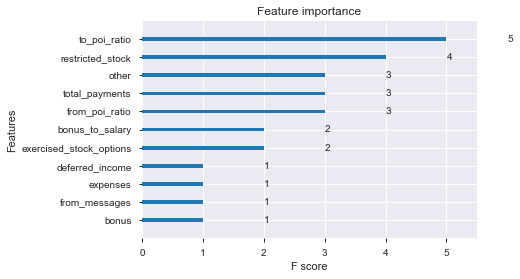

In [104]:
from xgboost import plot_importance
# model = XGBClassifier()
# model.fit(x_train, y_train)
plot_importance(bst)

### Upward features are important

Maybe we could construct a more precise train data that only contains important features.  
It may somewhat decrease the noise.

In [110]:
from sklearn.feature_selection import SelectFromModel
# from numpy import sort
# thresholds = sort(model.feature_importances_)

selection = SelectFromModel(model, prefit=True)
select_x_train = selection.transform(x_train) 
select_x_test = selection.transform(x_test)

x = []
a = list(selection.get_support(indices=True)) #抓出它用了train的欄位index
for feature_name in a:
    col_name = x_train.columns[feature_name]
    x.append(col_name)

select_x_train = pd.DataFrame(select_x_train,columns=x)
select_x_test = pd.DataFrame(select_x_test,columns=x)


# select_X_train.shape


### Ultimate perforance on public leaderboard 

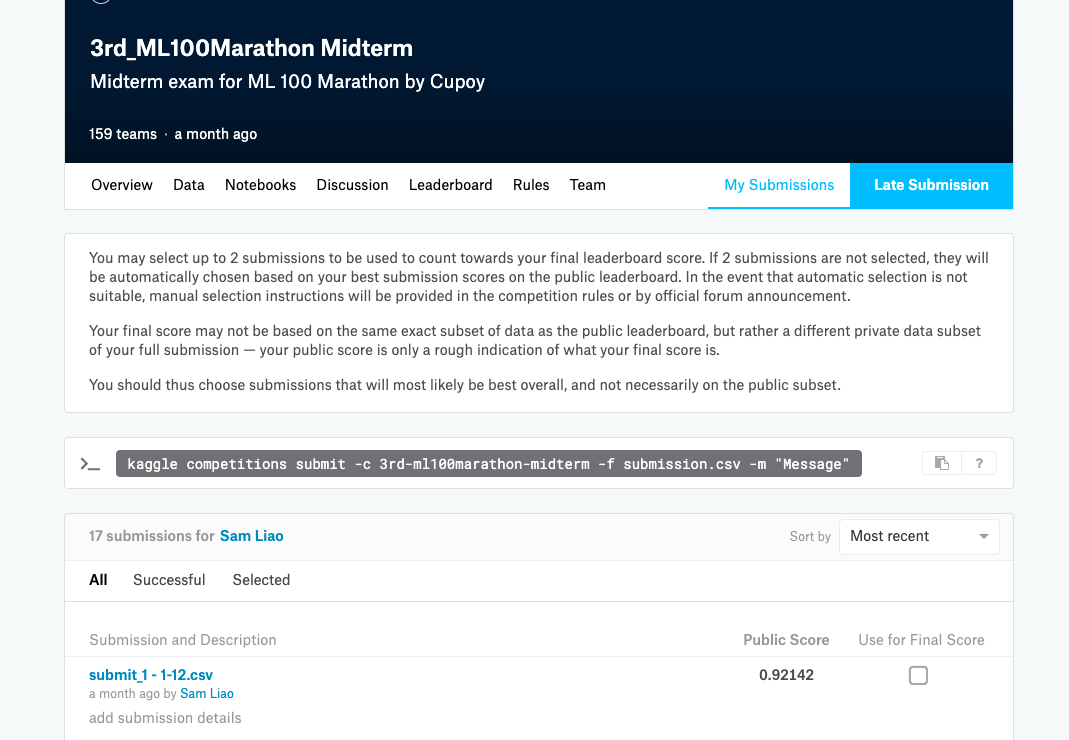

In [112]:
from IPython.display import Image
Image("Best Performace.png")